# Figures for Presentation in AMS Annual Meeting in Denver 2023 

## X-Band Precipitation Estimates for the Surface Atmosphere Integrated Field Laboratory (SAIL) Field Experiment
### Presenting Author: Joe O'Brien 

In [1]:
import os
import glob
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import fiona
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from math import atan2 as atan2
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyart
import act

ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/jrobrien/.conda/envs/sail_act_pyart/share/proj failed



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

## Read in the East River Domain file

In [3]:
east_river = gpd.read_file('../../data/site-locations/East_River.kml')

In [4]:
min_lat = 38.5
max_lat = 39.3
min_lon = -107.45
max_lon = -106.45
####min_lat = 38.71
####max_lat = 39.07
####min_lon = -107.17
####max_lon = -106.71
# zoomed in
zoom_min_lat = 38.85
zoom_max_lat = 39.05
zoom_min_lon = -107.1
zoom_max_lon = -106.80

In [21]:
# Define the splash locations [lon,lat]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
M1 = [-106.987, 38.9267]
snodgrass = [-106.978929, 38.926572]

sites = ["AMF2 M1", "Kettle Ponds", "Brush Creek", "Avery Point", 
         "Pumphouse Site", "Snodgrass"]

# Zip these together!
lons, lats = list(zip(M1,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      snodgrass))

## Define Helper Functions

In [6]:
def _generate_title(radar, ds, field, sweep):
    """ Generates a title for each plot. """
    time_str = ds['time'].data[0]
    fixed_angle = radar.fixed_angle['data'][sweep]
    line_one = "%.1f Deg. %s " % (fixed_angle, time_str)
    field_name = str(field)
    field_name = field_name.replace('_', ' ')
    field_name = field_name[0].upper() + field_name[1:]
    return line_one + '\n' + field_name

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [7]:
def plot_eastriver(axs, ncolor, scale_color='black', zoom=False):
    # Plot the East River Watershed domain
    east_river.plot(ax=axs, linewidth=2, edgecolor=ncolor, facecolor='None', linestyle=':',)

    axs.plot(0,
             0,
             color=ncolor,
             linestyle=':',
             label='East River Watershed')

    plt.legend(loc='upper right',
               fontsize=12)

    if zoom is True:
        plt.xlim(zoom_min_lon, zoom_max_lon)
        plt.ylim(zoom_min_lat, zoom_max_lat)
    else:
        plt.xlim(min_lon, max_lon)
        plt.ylim(min_lat, max_lat)

    # Add our scale bar
    add_scale_line(10.0, axs, projection=ccrs.PlateCarree(), 
                   color=scale_color, linewidth=3,
                   fontsize=14,
                   fontweight='bold')

    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(),
                       draw_labels=True,
                       linewidth=1, 
                       color='gray', 
                       alpha=0.3,
                       linestyle='--')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())

    # Make sure labels are only plotted on the left and bottom
    gl.top_labels = False
    gl.right_labels = False

    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}


In [24]:
def beam_block(radar, tif_file, radar_height_offset=10.0,
               beam_width=1.0):
    """
    Beam Block Radar Calculation.
    Parameters
    ----------
    radar : Radar
        Radar object used.
    tif_name : string
        Name of geotiff file to use for the
        calculation.
    radar_height_offset : float
        Add height to the radar altitude for radar towers.
    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.
    Returns
    -------
    pbb_all : array
        Array of partial beam block fractions for each
        gate in all sweeps.
    cbb_all : array
        Array of cumulative beam block fractions for
        each gate in all sweeps.
    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855
    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119
    """
    # Opening the tif file and getting the values ready to be
    # converted into polar values.
    rasterfile = tif_file
    data_raster = wrl.io.open_raster(rasterfile)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
        data_raster, nodata=None)
    #rastervalues_, rastercoords_, proj = wrl.georef.extract_raster_dataset(data_raster, nodata=-32768.)
    sitecoords = (np.float(radar.longitude['data']),
                  np.float(radar.latitude['data']),
                  np.float(radar.altitude['data'] + radar_height_offset))
    pbb_arrays = []
    cbb_arrays = []
    _range = radar.range['data']
    beamradius = wrl.util.half_power_radius(_range, beam_width)
    # Cycling through all sweeps in the radar object.
    print('Calculating beam blockage.')
    del data_raster
    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i] + 1
        elevs = radar.elevation['data'][index_start:index_end]
        azimuths = radar.azimuth['data'][index_start:index_end]
        rg, azg = np.meshgrid(_range, azimuths)
        rg, eleg = np.meshgrid(_range, elevs)
        nrays = azimuths.shape[0]              # number of rays
        nbins = radar.ngates                   # number of range bins
        bw = beam_width                        # half power beam width (deg)
        range_res = 60.                       # range resolution (meters)
        el = radar.fixed_angle['data'][i]
        coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
        coords = wrl.georef.spherical_to_proj(rg, azg, eleg,
                                              sitecoords, proj=proj)
        lon = coords[..., 0]
        lat = coords[..., 1]
        alt = coords[..., 2]
        polcoords = coords[..., :2]
        rlimits = (lon.min(), lat.min(), lon.max(), lat.max())

        #Clip the region inside our bounding box
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[0]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[0]:ind[3], ind[0]:ind[2]]
        polarvalues = wrl.ipol.cart_to_irregular_spline(
            rastercoords, rastervalues, polcoords, order=3,
            prefilter=False)
        # Calculate partial beam blockage using wradlib.
        pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
        pbb = np.ma.masked_invalid(pbb)
        pbb[pbb < 0] = 0.0
        pbb[pbb > 1] = 1.0
        pbb_arrays.append(pbb)
        # Calculate cumulative beam blockage using wradlib.
        cbb = wrl.qual.cum_beam_block_frac(pbb)
        cbb_arrays.append(cbb)
    pbb_all = np.ma.concatenate(pbb_arrays)
    cbb_all = np.ma.concatenate(cbb_arrays)
    return pbb_all, cbb_all

### A) RadCLss Location Figure

In [8]:
## Display the Domain with Column locations (maybe distance from radar?)

In [9]:
# grab a cmac file to overlay on-top of
radar = pyart.io.read('/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacS2.c1/ppi/202203/gucxprecipradarcmacS2.c1.20220314.024759.nc')

In [10]:
# Grab a RadCLss file
rad_ds = xr.open_dataset('/gpfs/wolf/atm124/proj-shared/gucxprecipradarradclss.c2/data/202203/xprecipradarradclss.c2.20220314.000000.nc')

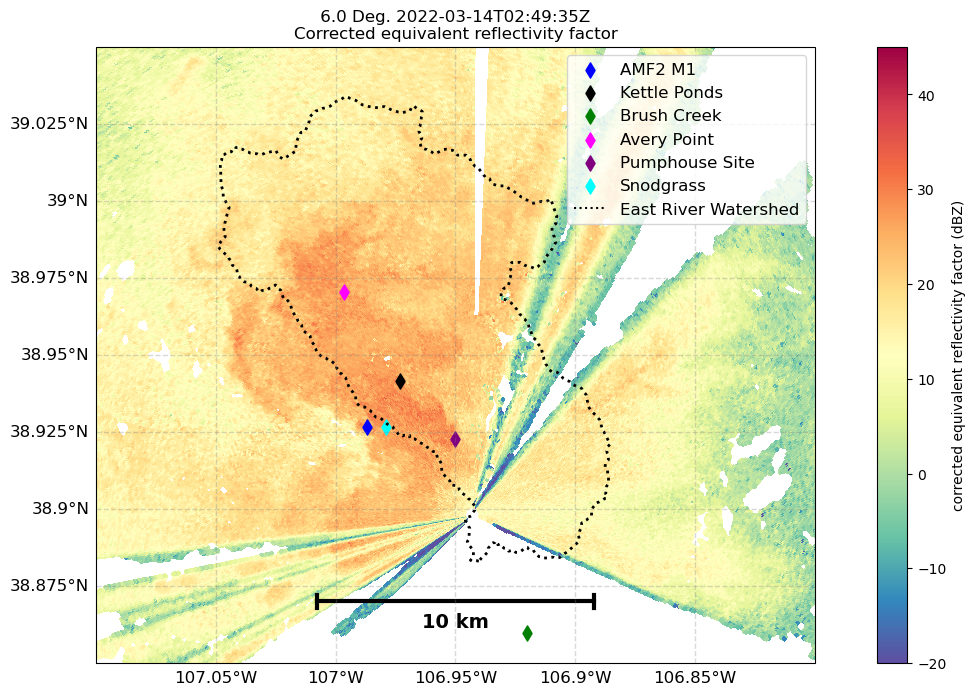

In [23]:
fig = plt.figure(figsize=(16, 8))

axs = plt.subplot(111, projection=ccrs.PlateCarree())

# Create the Radar Display Object
display = pyart.graph.RadarMapDisplay(radar)

# Plot the velocity texture

display.plot_ppi_map('corrected_reflectivity', 
                     ax=axs,
                     sweep=3, 
                     vmin=-20,
                     vmax=45,
                     lat_lines=None,
                     lon_lines=None,
                     min_lat=zoom_min_lat,
                     max_lat=zoom_max_lat,
                     min_lon=zoom_min_lon,
                     max_lon=zoom_max_lon,
                     ticklabs='',
                     embellish=False,
                     norm=None,
                     cmap="Spectral_r")


# Plot the sites!
ncolors = ['blue', 'black', 'green', 'fuchsia', 'purple', 'cyan']
i = 0
for nsite in sites:
    axs.scatter(lons[i], lats[i], c=ncolors[i], s=60, marker='d', label=nsite)
    i += 1

# Plot the East River Watershed domain
plot_eastriver(axs, 'black', zoom=True)

# Save the figure
plt.savefig('OBRIEN_AMS2023_RadCLss_Locations.png')

## B) RadCLss RHI View